# Contributions
Please try out the following and let me know if it helps at all
1. Trying new feature engineering combinations: None of the notebooks I've looked at have used abs()+sum(), or sem()

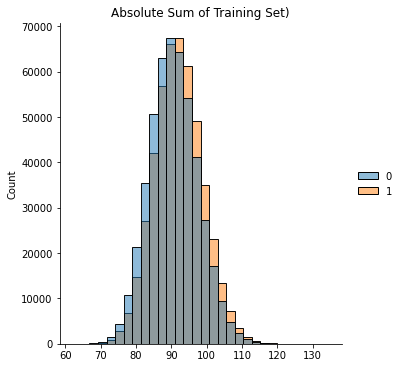
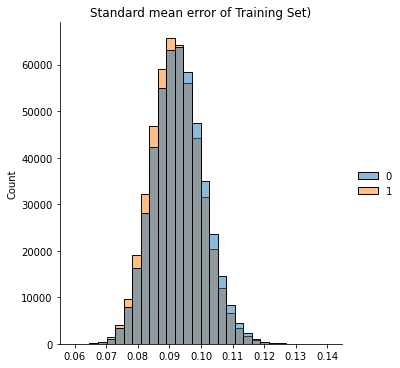

2. Adjusting learning rate: You can save time as well as fine tune your models

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from skimage.filters import threshold_otsu
import lightgbm as lgb
import gc
from tqdm import tqdm

SEED = 0

In [ ]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-sep-2021/train.csv", index_col='id')
test = pd.read_csv("/kaggle/input/tabular-playground-series-sep-2021/test.csv", index_col='id')

In [ ]:
features = [x for x in train.columns.values if x[0]=="f"]

In [ ]:
train['n_missing'] = train[features].isna().sum(axis=1)
train['abs_sum'] = train[features].abs().sum(axis=1)
train['sem'] = train[features].sem(axis=1)
train['std'] = train[features].std(axis=1)
train['avg'] = train[features].mean(axis=1)
train['max'] = train[features].max(axis=1)
train['min'] = train[features].min(axis=1)

test['n_missing'] = test[features].isna().sum(axis=1)
test['abs_sum'] = test[features].abs().sum(axis=1)
test['sem'] = test[features].sem(axis=1)
test['std'] = test[features].std(axis=1)
test['avg'] = test[features].mean(axis=1)
test['max'] = test[features].max(axis=1)
test['min'] = test[features].min(axis=1)


In [ ]:
# imputer = SimpleImputer(strategy="median")
# X = imputer.fit_transform(X)
# X_test = imputer.transform(X_test)

Idea taken from www.kaggle.com/dlaststark/tps-sep-single-xgboost-model
I have modified the choices using the following rationale:
1. Mean: normal distribution
2. Median: unimodal and skewed
3. Mode: all other cases

In [ ]:
fill_value_dict = {
    'f1': 'Mean', 
    'f2': 'Median', 
    'f3': 'Median', 
    'f4': 'Median', 
    'f5': 'Mode', 
    'f6': 'Mean', 
    'f7': 'Median', 
    'f8': 'Median', 
    'f9': 'Median', 
    'f10': 'Median', 
    'f11': 'Mean', 
    'f12': 'Median', 
    'f13': 'Mean', 
    'f14': 'Median', 
    'f15': 'Mean', 
    'f16': 'Median', 
    'f17': 'Median', 
    'f18': 'Median', 
    'f19': 'Median', 
    'f20': 'Median', 
    'f21': 'Median', 
    'f22': 'Mean', 
    'f23': 'Mode', 
    'f24': 'Median', 
    'f25': 'Median', 
    'f26': 'Median', 
    'f27': 'Median', 
    'f28': 'Median', 
    'f29': 'Mode', 
    'f30': 'Median', 
    'f31': 'Median', 
    'f32': 'Median', 
    'f33': 'Median', 
    'f34': 'Mean', 
    'f35': 'Median', 
    'f36': 'Mean', 
    'f37': 'Median', 
    'f38': 'Median', 
    'f39': 'Median', 
    'f40': 'Mode', 
    'f41': 'Median', 
    'f42': 'Mode', 
    'f43': 'Mean', 
    'f44': 'Median', 
    'f45': 'Median', 
    'f46': 'Mean', 
    'f47': 'Mode', 
    'f48': 'Mean', 
    'f49': 'Mode', 
    'f50': 'Mode', 
    'f51': 'Median', 
    'f52': 'Median', 
    'f53': 'Median', 
    'f54': 'Mean', 
    'f55': 'Mean', 
    'f56': 'Mode', 
    'f57': 'Mean', 
    'f58': 'Median', 
    'f59': 'Median', 
    'f60': 'Median', 
    'f61': 'Median', 
    'f62': 'Median', 
    'f63': 'Median', 
    'f64': 'Median', 
    'f65': 'Mode', 
    'f66': 'Median', 
    'f67': 'Median', 
    'f68': 'Median', 
    'f69': 'Mean', 
    'f70': 'Mode', 
    'f71': 'Median', 
    'f72': 'Median', 
    'f73': 'Median', 
    'f74': 'Mode', 
    'f75': 'Mode', 
    'f76': 'Mean', 
    'f77': 'Mode', 
    'f78': 'Median', 
    'f79': 'Mean', 
    'f80': 'Median', 
    'f81': 'Mode', 
    'f82': 'Median', 
    'f83': 'Mode', 
    'f84': 'Median', 
    'f85': 'Median', 
    'f86': 'Median', 
    'f87': 'Median', 
    'f88': 'Median', 
    'f89': 'Median', 
    'f90': 'Mean', 
    'f91': 'Mode', 
    'f92': 'Median', 
    'f93': 'Median', 
    'f94': 'Median', 
    'f95': 'Median', 
    'f96': 'Median', 
    'f97': 'Mean', 
    'f98': 'Median', 
    'f99': 'Median', 
    'f100': 'Mode', 
    'f101': 'Median', 
    'f102': 'Median', 
    'f103': 'Median', 
    'f104': 'Median', 
    'f105': 'Median', 
    'f106': 'Median', 
    'f107': 'Median', 
    'f108': 'Median', 
    'f109': 'Mode', 
    'f110': 'Median', 
    'f111': 'Median', 
    'f112': 'Median', 
    'f113': 'Mean', 
    'f114': 'Median', 
    'f115': 'Median', 
    'f116': 'Mode', 
    'f117': 'Median', 
    'f118': 'Mean'
}


for col in tqdm(features):
    if fill_value_dict.get(col)=='Mean':
        fill_value = train[col].mean()
    elif fill_value_dict.get(col)=='Median':
        fill_value = train[col].median()
    elif fill_value_dict.get(col)=='Mode':
        fill_value = train[col].mode().iloc[0]
    
    train[col].fillna(fill_value, inplace=True)
    test[col].fillna(fill_value, inplace=True)

In [ ]:
X = train.drop(["claim"], axis=1)
X_test = test
y = train["claim"]

In [ ]:
scaler = RobustScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [ ]:
del test, train, scaler
gc.collect()

In [ ]:
# Model hyperparameters
lgbm_params = {'objective': 'binary',
                'boosting_type': 'gbdt',
                'num_leaves': 148,
                'max_depth': 4,
                'learning_rate': 0.01,
                'n_estimators': 37456,
                'reg_alpha': 25.2,
                'reg_lambda': 98.6,
                'random_state': 0,
                'bagging_seed': 0, 
                'feature_fraction_seed': 0,
                'n_jobs': 4,
                'subsample': 0.7,
                'subsample_freq': 1,
                'colsample_bytree': 0.98,
                'min_child_samples': 99,
                'min_child_weight': 152,
                'metric': 'AUC',
                'verbosity': -1
              }

In [ ]:
%%time

splits = 5
kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)

preds = np.zeros(len(X_test))

for train_idx, valid_idx in kf.split(X, y):    
    lgb_train = lgb.Dataset(X[train_idx], y[train_idx], free_raw_data=False)
    lgb_valid = lgb.Dataset(X[valid_idx], y[valid_idx], free_raw_data=False)
    
    print('#' * 40)

    lgbm_params['learning_rate'] = 0.05
    
    model = lgb.train(lgbm_params,
                      lgb_train,
                      verbose_eval=-1,
                      valid_sets=[lgb_valid])
    
    lgbm_params['learning_rate'] = 0.01
    
    model = lgb.train(lgbm_params,
                      lgb_train,
                      init_model=model,
                      verbose_eval=-1,
                      valid_sets=[lgb_valid])
    
    preds += model.predict(X_test) / splits
    
    gc.collect()

In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-sep-2021/sample_solution.csv', index_col='id')
submission['claim'] = preds
submission.to_csv('submission.csv')